### Predicting formation enthalpies for solid solutions of Lanthanides Orthophosphates


In [5]:
import os
import sys
import inspect

print(sys.version)

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
grandparentdir = os.path.dirname(parentdir)

sys.path.insert(0, grandparentdir) 

3.9.6 (default, Nov 10 2023, 13:38:27) 
[Clang 15.0.0 (clang-1500.1.0.2.5)]


In [6]:
import read_data
import featureSpan
import lasso
import Utils
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.optimize
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from sklearn.linear_model import Lasso
from itertools import combinations, product
import itertools
import math
import pandas as pd

import matplotlib as mpl
from pylab import cm

import matplotlib.font_manager as fm

# Xenotime

#### Load data from files

In [7]:
list1 = read_data.readData("../../data/DATA_HE_xenotime.dat")
print("Shape of List1 is {}".format(list1.shape))
print(list1)

Shape of List1 is (525, 4)
[[5.70000000e+01 5.80000000e+01 7.50000000e-01 2.31598225e-01]
 [5.70000000e+01 5.80000000e+01 6.25000000e-01 2.78958493e-01]
 [5.70000000e+01 5.80000000e+01 5.00000000e-01 2.97583757e-01]
 ...
 [7.00000000e+01 7.10000000e+01 5.00000000e-01 7.77590152e-02]
 [7.00000000e+01 7.10000000e+01 3.75000000e-01 7.09266168e-02]
 [7.00000000e+01 7.10000000e+01 2.50000000e-01 5.91211365e-02]]


In [8]:
list2 = read_data.readCSVData("../../data/Data_Ln-xenotime.csv", material="xenotime", Volume=True)
print("Shape of List2 is {}".format(list2.shape))
print((list2))

Shape of List2 is (15, 9)
[[ 57.         138.90547     19.1773      91.7         11.
    1.1         49.95        83.16086967   1.16      ]
 [ 58.         140.116       20.198       99.73        12.
    1.12        36.758       81.11579575   1.143     ]
 [ 59.         140.90765     21.624      112.27        12.3
    1.13        38.98        79.31176899   1.126     ]
 [ 60.         144.242       22.1        120.19        12.95
    1.14        40.41        77.89975607   1.109     ]
 [ 61.         145.          22.3        127.26        13.6
    1.13        41.1         76.63526873   1.093     ]
 [ 62.         150.36        23.4        137.16        14.25
    1.17        41.4         75.42961529   1.079     ]
 [ 63.         151.964       24.92       143.83        14.9
    1.2         42.7         74.36126731   1.066     ]
 [ 64.         157.25        20.63       149.42        15.9
    1.2         44.          73.33463097   1.053     ]
 [ 65.         158.92535     21.91       156.33       

#### Generated Elemental Training/Testing sets from loaded data

In [9]:
listX, listY = featureSpan.computeMean(list1, list2)
X = np.asarray(listX)
Y = np.asarray(listY)
mean_list = ["WM", "QWM", "AD"]
elemental_list = ["Z", "M", "IP2+", "E", "charge", "electronegativity", "IP3+", "Vol", "R"]
# Get shape of Input set X
m, n = X.shape
feature_list = []

#Generate the list containing the names of all features
# All features = mean_list' * elemental_list
for i in mean_list:
    for j in elemental_list:
        feature_list.append("["+i+":"+j+"]")
        
print("The elemental features are: \n {}".format(feature_list))
# Generate new features as x^3; number = 33
for i in range(n):
    tmp = np.reshape(X[:,i] * X[:,i] * X[:,i], (-1, 1))
    X = np.append(X, tmp, axis=1)
    feature_list.append(feature_list[i]+"^3")
    
print(X.shape)
# Generate new features as x^2: number = 33
for i in range(n):
    tmp = np.reshape(X[:,i] * X[:,i], (-1, 1))
    #print(tmp.shape)
    X = np.append(X, tmp, axis=1)
    feature_list.append(feature_list[i]+"^2")
print(X.shape)

# Generate new features as x1*x2: number = 33 * 32 / 2 = 528
for i in range(n):
    for j in range(i):
        tmp = np.reshape(X[:,i] * X[:,j], (-1, 1))
        X = np.append(X, tmp, axis=1)
        feature_list.append(feature_list[i]+"*"+feature_list[j])
print(X.shape)

# Generate new features as x1^2*x2; number = 33 * 32 / 2 = 528
for i in range(n):
    for j in range(i):
        tmp = np.reshape(X[:,i] * X[:,i]* X[:,j], (-1, 1))
        X = np.append(X, tmp, axis=1)
        feature_list.append(feature_list[i]+"^2"+"*"+feature_list[j])

print(X.shape)

# Generate new features as x1*x2*x3; number = 33 * 32 * 31 / 3 / 2 = 5456
for i in range(n):
    for j in range(i):
        for k in range(j):
            tmp = np.reshape(X[:,i] * X[:,j]* X[:,k], (-1, 1))
            X = np.append(X, tmp, axis=1)
            feature_list.append(feature_list[i]+"*"+feature_list[j]+"*"+feature_list[k])
print(X.shape)

The elemental features are: 
 ['[WM:Z]', '[WM:M]', '[WM:IP2+]', '[WM:E]', '[WM:charge]', '[WM:electronegativity]', '[WM:IP3+]', '[WM:Vol]', '[WM:R]', '[QWM:Z]', '[QWM:M]', '[QWM:IP2+]', '[QWM:E]', '[QWM:charge]', '[QWM:electronegativity]', '[QWM:IP3+]', '[QWM:Vol]', '[QWM:R]', '[AD:Z]', '[AD:M]', '[AD:IP2+]', '[AD:E]', '[AD:charge]', '[AD:electronegativity]', '[AD:IP3+]', '[AD:Vol]', '[AD:R]']
(525, 54)
(525, 81)
(525, 432)
(525, 783)
(525, 3708)


In [10]:
dfX = pd.DataFrame(data=X, columns=feature_list)

dfX.head()

dfX.std() == 0
dfX=dfX.loc[:, dfX.std() > 0]
dfX.head()

,[WM:Z],[WM:M],[WM:IP2+],[WM:E],[WM:charge],[WM:electronegativity],[WM:IP3+],[WM:Vol],[WM:R],[QWM:Z],...,[AD:R]*[AD:Vol]*[QWM:IP3+],[AD:R]*[AD:Vol]*[QWM:Vol],[AD:R]*[AD:Vol]*[QWM:R],[AD:R]*[AD:Vol]*[AD:Z],[AD:R]*[AD:Vol]*[AD:M],[AD:R]*[AD:Vol]*[AD:IP2+],[AD:R]*[AD:Vol]*[AD:E],[AD:R]*[AD:Vol]*[AD:charge],[AD:R]*[AD:Vol]*[AD:electronegativity],[AD:R]*[AD:Vol]*[AD:IP3+]
0,57.250,139.208102,19.432475,93.70750,11.250,1.1050,46.652,82.649601,1.155750,57.100000,...,0.422678,0.721021,0.010067,0.004346,0.005261,0.004436,0.034897,0.004346,0.000087,0.05733
1,57.375,139.359419,19.560063,94.71125,11.375,1.1075,45.003,82.393967,1.153625,57.264706,...,0.403793,0.718093,0.010043,0.004346,0.005261,0.004436,0.034897,0.004346,0.000087,0.05733
2,57.500,139.510735,19.687650,95.71500,11.500,1.1100,43.354,82.138333,1.151500,57.500000,...,0.376814,0.713911,0.010008,0.004346,0.005261,0.004436,0.034897,0.004346,0.000087,0.05733
3,57.625,139.662051,19.815238,96.71875,11.625,1.1125,41.705,81.882698,1.149375,57.735294,...,0.349835,0.709728,0.009974,0.004346,0.005261,0.004436,0.034897,0.004346,0.000087,0.05733
4,57.750,139.813368,19.942825,97.72250,11.750,1.1150,40.056,81.627064,1.147250,57.900000,...,0.330950,0.706801,0.009949,0.004346,0.005261,0.004436,0.034897,0.004346,0.000087,0.05733


In [11]:
print(len(dfX.columns.values))
np.array(dfX.columns.values)

3708


array(['[WM:Z]', '[WM:M]', '[WM:IP2+]', ...,
       '[AD:R]*[AD:Vol]*[AD:charge]',
       '[AD:R]*[AD:Vol]*[AD:electronegativity]',
       '[AD:R]*[AD:Vol]*[AD:IP3+]'], dtype=object)

In [12]:
def LassoFit(lmb, X, Y, max_iter=100000, standardization = True):
    
    scaler = StandardScaler()
    scaler.fit(X)
    X_standardized = scaler.transform(X)
    lasso =  Lasso(alpha=lmb, max_iter=max_iter)
    lasso.fit(X_standardized, Y.copy())
    coef =  lasso.coef_
    selected_indices = coef.nonzero()[0]
    selected_features = np.array(dfX.columns.values)[selected_indices]
    Y_predict = lasso.predict(X_standardized)
    MAE, MSE, MAPE = Utils.compute_error(Y.copy(), Y_predict)
        
    return coef, selected_indices, selected_features, MAE, MSE, MAPE

LassoFit(0.01, dfX, Y)

(array([-0., -0., -0., ...,  0.,  0.,  0.]),
 array([  39,   42,   79,  103,  210,  217,  226,  231,  403,  564,  647,
         656,  668,  732,  734,  735,  737,  744,  746, 2992, 3215, 3319,
        3328]),
 array(['[QWM:E]^3', '[QWM:IP3+]^3', '[AD:Vol]^2', '[WM:Vol]*[WM:M]',
        '[QWM:Vol]*[QWM:Z]', '[QWM:R]*[WM:Z]', '[QWM:R]*[QWM:Z]',
        '[QWM:R]*[QWM:electronegativity]', '[AD:Vol]*[AD:charge]',
        '[QWM:Vol]^2*[QWM:E]', '[AD:E]^2*[WM:electronegativity]',
        '[AD:E]^2*[QWM:electronegativity]',
        '[AD:charge]^2*[WM:electronegativity]', '[AD:Vol]^2*[WM:Z]',
        '[AD:Vol]^2*[WM:IP2+]', '[AD:Vol]^2*[WM:E]',
        '[AD:Vol]^2*[WM:electronegativity]', '[AD:Vol]^2*[QWM:E]',
        '[AD:Vol]^2*[QWM:electronegativity]',
        '[AD:IP3+]*[AD:M]*[QWM:electronegativity]',
        '[AD:Vol]*[QWM:Vol]*[QWM:E]',
        '[AD:Vol]*[AD:charge]*[WM:electronegativity]',
        '[AD:Vol]*[AD:charge]*[QWM:electronegativity]'], dtype=object),
 0.1421508589524771,
 0.03

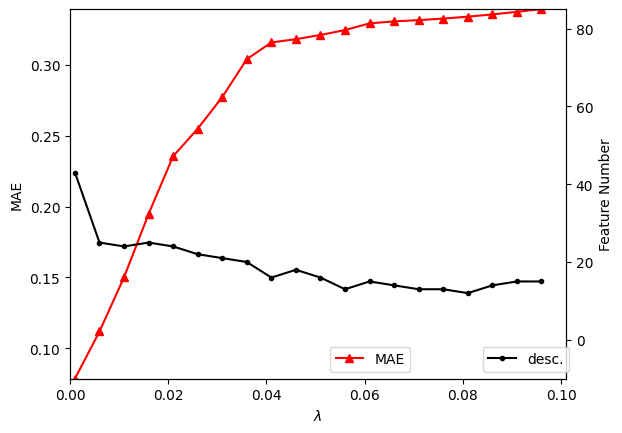

In [13]:
def LassoPlot(X, Y, min, max, step, standardization = True ):
    
    scaler = StandardScaler()
    scaler.fit(X)
    X_standardized = scaler.transform(X)
    
    coefs = []
    indices = []
    MAEs = []
    MSEs = []
    MAPEs = []
    lmbs = []
    nbs = []

    for lmbda in np.arange (min, max, step):
        lmbs.append(np.array(lmbda))
        coef, selected_indices, selected_features, MAE, MSE, MAPE = LassoFit(lmbda, X_standardized, Y)
        coefs.append(np.array(coef))
        indices.append(np.array(selected_indices))
        nbs.append(len(selected_indices))
        MAEs.append(np.array(MAE))
        MSEs.append(np.array(MSE))
        MAPEs.append(np.array(MAPE))
    
    fig, ax = plt.subplots()
    twin = ax.twinx()
    ax.plot(lmbs, MAEs, label='MAE',marker="^", color='red')
    pparam = dict(xlabel='$\lambda$', ylabel='MAE')
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.set_xlim(0.0005, max)
    ax.legend(loc='lower right', bbox_to_anchor=(0.7, 0.0))
    
    twin.plot(lmbs, nbs, label='desc.', color='black', marker=".")
    twin.set_ylabel("Feature Number")
    twin.autoscale(tight=True)
    twin.set_xlim(0, max)
    twin.set_ylim(-10, 85)
    twin.legend(loc='lower right', bbox_to_anchor=(1.02, 0.0))        
    fig.savefig('lasso_mean_xenotime_lassol1.pdf')
    
LassoPlot(dfX, Y, 0.001, 0.101, 0.005)

In [14]:
#### Define a function which fits Lasso to have no more nonzero coefficients than a given threshold 
def LassoSelect(X, Y, min, max, step, threshold, standardization = True):
    
    scaler = StandardScaler()
    scaler.fit(X)
    X_standardized = scaler.transform(X)
        
    found = False
    for lmbda in np.arange (min, max, step):
        coef, selected_indices, selected_features, MAE, MSE, ME = LassoFit(lmbda, X.copy(), Y.copy())
        if len(selected_indices) <= threshold:
            found = True
            break
    
    if found:
        print("FOUND with threshold: {}".format(threshold))
        print("Lambda: {}, nnz: {}, MAE: {}, MSE: {}, MAPE: {}".format(lmbda, len(selected_indices), MAE, MSE, ME))
            
    else:
        print("NOT FOUND with threshold: {}".format(threshold))
        print("Closest are: ")
        print("Lambda: {}, nnz: {}, MAE: {}, MSE: {}, MAPE: {}".format(lmbda, len(selected_indices), MAE, MSE, ME))
     
    X_reduced = X[selected_features]
    
    return X_reduced


X_reduced = LassoSelect(dfX, Y, 0.001, 0.101, 0.005, 30)
X_reduced.head()

FOUND with threshold: 30
Lambda: 0.006, nnz: 25, MAE: 0.11178242365746453, MSE: 0.022155603303600415, MAPE: 0.2796708941377634


,[QWM:E]^3,[QWM:IP3+]^3,[AD:IP2+]^3,[AD:Vol]^2,[WM:Vol]*[WM:M],[QWM:M]*[WM:Vol],[QWM:Vol]*[QWM:Z],[QWM:Vol]*[QWM:M],[QWM:R]*[WM:Z],[QWM:R]*[QWM:Z],...,[AD:Vol]^2*[WM:IP2+],[AD:Vol]^2*[WM:E],[AD:Vol]^2*[WM:electronegativity],[AD:Vol]^2*[QWM:IP2+],[AD:Vol]^2*[QWM:E],[AD:Vol]^2*[QWM:electronegativity],[QWM:M]*[WM:Vol]*[WM:IP2+],[AD:electronegativity]*[AD:charge]*[AD:Z],[AD:Vol]*[QWM:Vol]*[QWM:E],[AD:Vol]*[AD:IP3+]*[QWM:E]
0,791530.133748,115009.639445,0.132924,1.045582,11505.494154,11490.486681,4736.808286,11533.134608,66.312675,66.138930,...,20.318243,97.978859,1.155368,20.158159,96.719456,1.152231,223288.595162,0.0025,7846.654511,623.900708
1,825969.265924,100272.427504,0.132924,1.045582,11482.375343,11471.374567,4731.182889,11502.778309,66.296813,66.169368,...,20.451646,99.028362,1.157982,20.333937,98.102330,1.155675,224380.803486,0.0025,7926.528247,632.821108
2,876879.689651,81486.848126,0.132924,1.045582,11459.179168,11459.179168,4722.954131,11459.179168,66.211250,66.211250,...,20.585049,100.077865,1.160596,20.585049,100.077865,1.160596,225604.308751,0.0025,8039.053158,645.564536
3,929840.257934,65207.515625,0.132924,1.045582,11435.905630,11446.838145,4714.498928,11415.305910,66.124687,66.251250,...,20.718452,101.127368,1.163210,20.836161,102.053399,1.165516,226821.816462,0.0025,8149.718742,658.307964
4,968154.163324,55207.110282,0.132924,1.045582,11412.554729,11427.376531,4708.445552,11384.431529,66.106425,66.278130,...,20.851855,102.176870,1.165824,21.011939,103.436274,1.168960,227894.170366,0.0025,8226.078352,667.228364


In [15]:
def LassoL0(X, Y, nnz):    
    nr, nc = X.shape
    X = np.column_stack((X, np.ones(nr)))
    se_min = np.inner(Y, Y)
    coef_min, permu_min = None, None
    for permu in combinations(range(nc), nnz):
        X_ls = X[:, permu + (-1,)]
        coef, se, __1, __2 = np.linalg.lstsq(X_ls, Y, rcond=-1)
        try:
            if se[0] < se_min: 
                se_min = se[0]
                coef_min, permu_min = coef, permu
        except:
            pass
        
    return coef_min, permu_min

In [16]:
def LassoL0Fit(X_reduced, Y, nnz, log=True):
    
    scaler = StandardScaler()
    scaler.fit(X_reduced)
    X_std = scaler.transform(X_reduced)
    
    nr, nc = X_reduced.shape
   
    coefficients, selected_indices = LassoL0(X_std, Y, nnz)
   
    coefficients = np.array(coefficients)
    selected_indices = np.array(selected_indices)
    feature_reduced = np.array(X_reduced.columns.values)
    feature_list_selected = feature_reduced[selected_indices]
    
    X_selected = X_reduced[feature_list_selected]

    mean_selected = X_selected.mean()
    std_selected = X_selected.std()

    
    if log:
        print("Lasso: selected coefficients are: {}".format(coefficients))
        print("Lasso: selected features are: {}".format(feature_list_selected))
        
    #-mean/std
    mean_std = []
    for i in range(len(selected_indices)):
        mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
 
    sum_mean_std = sum(mean_std)

    for i in range(len(selected_indices)):
        coefficients[i] = coefficients[i] / std_selected[i]

    
    coefficients[len(selected_indices)] -= sum_mean_std
    
    function = str(coefficients[0])+" * "+feature_list_selected[0]
    
    for i in range(1, len(selected_indices)):
        if coefficients[i] >= 0:
            function += " + " + str(coefficients[i])+" * "+feature_list_selected[i]
        else:
            function += " - " + str(abs(coefficients[i]))+" * "+feature_list_selected[i]

    
    if coefficients[len(selected_indices)] >= 0:
        function += " + " + str(coefficients[len(selected_indices)])
    else:
        function += " - " + str(abs(coefficients[len(selected_indices)]))
    
    if log:
        print("Constructed function is: {}".format(function))

    X_selected = np.column_stack((X_selected, np.ones(X_selected.shape[0])))
    Y_predict = X_selected[:,0] * coefficients[0]

    for i in range(1,len(selected_indices)+1):
        Y_predict = Y_predict + X_selected[:,i] * coefficients[i]
    
    if log:
        Utils.print_error(Y.copy(),Y_predict,"Lasso L0: {} coef".format(nnz))
    
    return Y_predict, coefficients, selected_indices

In [17]:
LassoL0Fit(X_reduced, Y.copy(), 1);

Lasso: selected coefficients are: [3.65785793 3.1736172 ]
Lasso: selected features are: ['[AD:Vol]^2*[WM:Z]']
Constructed function is: 0.00424576943292084 * [AD:Vol]^2*[WM:Z] + 0.050619525314429925
Lasso L0: 1 coef
Mean absolute error: 0.3303497087534983
Mean squared error: 0.28645092460383603
Mean absolute percentage error: 0.21469099886632115


/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_22600/1248470983.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_22600/1248470983.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients[i] = coefficients[i] / std_selected[i]


In [18]:
LassoL0Fit(X_reduced, Y.copy(), 2);

Lasso: selected coefficients are: [0.28690374 3.38542289 3.1736172 ]
Lasso: selected features are: ['[AD:charge]^2*[WM:electronegativity]' '[AD:Vol]^2*[WM:Z]']
Constructed function is: 0.051362972619119776 * [AD:charge]^2*[WM:electronegativity] + 0.003929547096613459 * [AD:Vol]^2*[WM:Z] + 0.02745899110745631
Lasso L0: 2 coef
Mean absolute error: 0.32470784375181483
Mean squared error: 0.27835803172057527
Mean absolute percentage error: 0.16723797183617928


/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_22600/1248470983.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_22600/1248470983.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients[i] = coefficients[i] / std_selected[i]


In [19]:
LassoL0Fit(X_reduced, Y.copy(), 3);

Lasso: selected coefficients are: [-3.36705937  3.37273822  2.88009829  3.1736172 ]
Lasso: selected features are: ['[QWM:E]^3' '[QWM:R]*[QWM:Z]' '[AD:Vol]^2*[WM:Z]']
Constructed function is: -2.0356700527988576e-06 * [QWM:E]^3 + 4.235864456757379 * [QWM:R]*[QWM:Z] + 0.0033430038854495546 * [AD:Vol]^2*[WM:Z] - 278.3422373240019
Lasso L0: 3 coef
Mean absolute error: 0.20774946202468464
Mean squared error: 0.0698418487027675
Mean absolute percentage error: 0.5705200897231218


/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_22600/1248470983.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_22600/1248470983.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients[i] = coefficients[i] / std_selected[i]


In [20]:
LassoL0Fit(X_reduced, Y.copy(), 4);

Lasso: selected coefficients are: [-3.57411003  3.18857467  0.40905068  2.90580731  3.1736172 ]
Lasso: selected features are: ['[QWM:E]^3' '[QWM:R]*[QWM:Z]' '[QWM:Vol]^2*[QWM:E]' '[AD:Vol]^2*[WM:Z]']
Constructed function is: -2.1608495578935463e-06 * [QWM:E]^3 + 4.004571137917821 * [QWM:R]*[QWM:Z] + 6.6916445733144045e-06 * [QWM:Vol]^2*[QWM:E] + 0.003372845000601516 * [AD:Vol]^2*[WM:Z] - 267.63291792319393
Lasso L0: 4 coef
Mean absolute error: 0.17906469276863157
Mean squared error: 0.05421134130797086
Mean absolute percentage error: 0.5865879808330401


/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_22600/1248470983.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_22600/1248470983.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients[i] = coefficients[i] / std_selected[i]


In [21]:
LassoL0Fit(X_reduced, Y.copy(), 5);

Lasso: selected coefficients are: [-3.70688674  0.47972629  2.42620546  0.97339989  2.77814129  3.1736172 ]
Lasso: selected features are: ['[QWM:E]^3' '[QWM:Vol]*[QWM:Z]' '[QWM:R]*[QWM:Z]' '[QWM:Vol]^2*[QWM:E]'
 '[AD:Vol]^2*[WM:Z]']
Constructed function is: -2.2411242273179706e-06 * [QWM:E]^3 + 0.01406713391612655 * [QWM:Vol]*[QWM:Z] + 3.047102031367479 * [QWM:R]*[QWM:Z] + 1.5923811995925925e-05 * [QWM:Vol]^2*[QWM:E] + 0.003224659778616416 * [AD:Vol]^2*[WM:Z] - 276.3861142305483
Lasso L0: 5 coef
Mean absolute error: 0.15017073710869056
Mean squared error: 0.033785034281420906
Mean absolute percentage error: 0.5143876966615714


/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_22600/1248470983.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_std.append(coefficients[i] * mean_selected[i]/std_selected[i])
/var/folders/_0/q128s8pd1lb95k4pms0qlpw40000gn/T/ipykernel_22600/1248470983.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients[i] = coefficients[i] / std_selected[i]
